### **Import library**

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import kagglehub

### **Load data**

In [48]:
path = kagglehub.dataset_download("hhenry/finance-factoring-ibm-late-payment-histories")

Using Colab cache for faster access to the 'finance-factoring-ibm-late-payment-histories' dataset.


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/finance-factoring-ibm-late-payment-histories


In [49]:
df = pd.read_csv("/kaggle/input/finance-factoring-ibm-late-payment-histories/WA_Fn-UseC_-Accounts-Receivable.csv")

### **Quick explore data**

Let's perform initial data inspection to understand structure, data types, and
missing values.

In [50]:
df.sample(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
2152,406,2621-XCLEH,9/24/2012,8691041327,4/16/2012,5/16/2012,74.06,No,5/30/2012,Paper,44,14
2343,406,5164-VMYWJ,11/27/2013,9468928435,11/15/2012,12/15/2012,62.62,No,12/4/2012,Paper,19,0
682,391,5196-TWQXF,6/20/2012,2811916189,10/28/2013,11/27/2013,54.07,No,11/13/2013,Electronic,16,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


Let's correct types of data

In [52]:
date_cols = ['PaperlessDate','InvoiceDate', 'DueDate', 'SettledDate']

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

*Since `countryCode` and `invoiceNumber` are identifiers rather than numerical values for analysis, they should not be stored as integers. Instead, it is more appropriate to convert them into object (or string) types so that Pandas treats them as categorical data rather than quantitative variables.*

In [53]:
df['invoiceNumber'] = df['invoiceNumber'].astype(str)
df['countryCode'] = df['countryCode'].astype(str)

Recheck the data's type:

In [54]:
df.dtypes

,0
countryCode,object
customerID,object
PaperlessDate,datetime64[ns]
invoiceNumber,object
InvoiceDate,datetime64[ns]
DueDate,datetime64[ns]
InvoiceAmount,float64
Disputed,object
SettledDate,datetime64[ns]
PaperlessBill,object


In [55]:
invoice_min = df['InvoiceDate'].min()
invoice_max = df['InvoiceDate'].max()
settled_min = df['SettledDate'].min()
settled_max = df['SettledDate'].max()

print("Data Period Summary:")
print(f"- InvoiceDate range: {invoice_min.date()} to {invoice_max.date()}  ({(invoice_max - invoice_min).days + 1} days)")
print(f"- SettledDate range: {settled_min.date()} to {settled_max.date()}  ({(settled_max - settled_min).days + 1} days)")

Data Period Summary:
- InvoiceDate range: 2012-01-03 to 2013-12-02  (700 days)
- SettledDate range: 2012-01-13 to 2014-01-09  (728 days)


Now, I will check for duplicate records.

In [56]:
df.columns

Index(['countryCode', 'customerID', 'PaperlessDate', 'invoiceNumber',
       'InvoiceDate', 'DueDate', 'InvoiceAmount', 'Disputed', 'SettledDate',
       'PaperlessBill', 'DaysToSettle', 'DaysLate'],
      dtype='object')

In [57]:
df.duplicated().sum()

np.int64(0)

In [58]:
df['invoiceNumber'].duplicated().sum()

np.int64(0)

### **Check missing important dates**


In [59]:
date_cols = ['PaperlessDate','InvoiceDate', 'DueDate', 'SettledDate']
df[date_cols].isnull().sum()

,0
PaperlessDate,0
InvoiceDate,0
DueDate,0
SettledDate,0


### **Check payment date**

In [60]:
df[df['SettledDate'] < df['InvoiceDate']]


,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate


> Empty result indicates no invalid settlements before invoicing

### **Create Payment Status index**

Payment Status need to be created to support classification analysis.

In which:

1 = Late, 0 = On-time

In [61]:
df['PaymentStatus'] = np.where(df['DaysLate'] > 0, 1, 0)

In [62]:
df.sample(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaymentStatus
2192,818,3271-HYHDN,2013-04-28,8871842653,2012-03-05,2012-04-04,57.07,No,2012-03-14,Paper,9,0,0
1882,406,2621-XCLEH,2012-09-24,7619716138,2012-11-18,2012-12-18,86.39,Yes,2013-02-01,Electronic,75,45,1
1210,391,2676-DZINU,2012-10-19,4887614261,2012-06-12,2012-07-12,60.19,No,2012-07-05,Paper,23,0,0


### **Create Aging Buckets**

Categorize invoices into aging buckets commonly used in AR reporting. We can compare invoice value concentration across aging buckets.

In [63]:
def aging_bucket(x):
    if x <= 0:
        return 'On-time'
    elif x <= 30:
        return '0–30'
    elif x <= 60:
        return '31–60'
    elif x <= 90:
        return '61–90'
    else:
        return '>90'

df['AgingBucket'] = df['DaysLate'].apply(aging_bucket)

In [64]:
df.sample(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaymentStatus,AgingBucket
1281,391,3569-VJWXS,2013-04-09,5137377854,2013-05-07,2013-06-06,50.63,No,2013-05-21,Electronic,14,0,0,On-time
1275,391,2820-XGXSB,2012-01-26,5120935092,2012-02-03,2012-03-04,83.15,No,2012-02-12,Electronic,9,0,0,On-time
759,770,2026-XLBER,2012-11-12,3115534110,2013-05-31,2013-06-30,70.66,Yes,2013-06-26,Electronic,26,0,0,On-time


### **Frequency**

In [65]:
freq = df.groupby('customerID')['invoiceNumber'].count()
df['TransactionFrequency'] = df['customerID'].map(freq)

In [ ]:
df.sample(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaymentStatus,AgingBucket,TransactionFrequency
1085,770,2687-XWAMA,2013-04-03,4384814254,2013-04-30,2013-05-30,27.34,No,2013-05-10,Electronic,10,0,0,On-time,28
795,391,6708-DPYTF,2012-08-02,3228259319,2012-11-11,2012-12-11,94.19,No,2012-12-15,Electronic,34,4,1,0–30,30
175,391,5920-DPXLN,2012-11-11,649771974,2013-04-26,2013-05-26,68.35,No,2013-05-07,Electronic,11,0,0,On-time,28


## **EXPLORATORY DATA ANALYSIS (EDA)**

Now, let's summarize numerical variables

In [66]:
numeric_cols = df.select_dtypes(include=['number'])

In [67]:
numeric_summary = numeric_cols.describe().round(2)
print(numeric_summary)

       InvoiceAmount  DaysToSettle  DaysLate  PaymentStatus  \
count        2466.00       2466.00   2466.00        2466.00   
mean           59.90         26.44      3.44           0.36   
std            20.44         12.33      6.29           0.48   
min             5.26          0.00      0.00           0.00   
25%            46.40         18.00      0.00           0.00   
50%            60.56         26.00      0.00           0.00   
75%            73.76         35.00      5.00           1.00   
max           128.28         75.00     45.00           1.00   

       TransactionFrequency  
count               2466.00  
mean                  25.58  
std                    4.80  
min                   15.00  
25%                   22.00  
50%                   26.00  
75%                   29.00  
max                   36.00  


> The `mean` and `std` show that most invoices are moderate in amount (~60), settled within about 26 days, and generally not late.

> However, the wide gaps between `min` and `max` values indicate the possibility of outliers in all three variables:
* very small or large invoice amounts
* settlements that are either immediate or unusually long, and
* late payments extending beyond 30 days.

### **Calculate Payment Delay**

Mean calculation provides a baseline metric

In [68]:
df['DaysLate'].mean().round(2)

np.float64(3.44)

In [69]:
print("Average payment delay:", df['DaysLate'].mean().round(2), "days")
print("Average delay for late payments only:", df[df['DaysLate'] > 0]['DaysLate'].mean().round(2), "days")

Average payment delay: 3.44 days
Average delay for late payments only: 9.68 days


### **Distribution of payment delay**

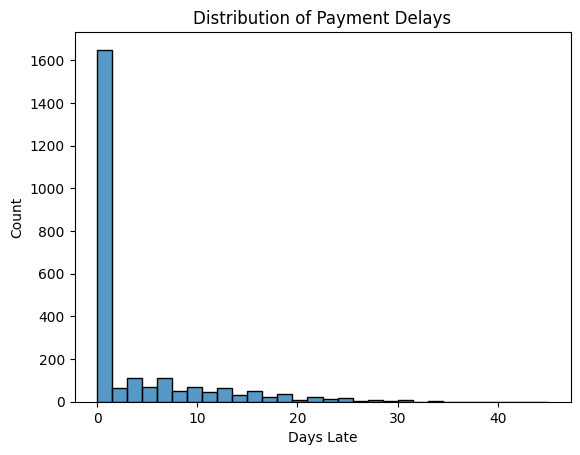

In [70]:
plt.figure()
sns.histplot(df['DaysLate'], bins=30)
plt.title('Distribution of Payment Delays')
plt.xlabel('Days Late')
plt.savefig(
    'Dayslate.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

> * **Most payments are on time.** The highest bars near zero show that most invoices have little or no delay.

>* **Average is affected by outliers**. The mean delay (~3.4 days) is pushed up by a few extreme late payments.

> * **Late payment risk comes from a small group**, not the majority of customers.

=> Overall payment behavior is good, but a small high-risk segment drives disproportionate delay risk.





In [71]:
heatmap_cols = [
    'DaysLate',
    'TransactionFrequency',
    'InvoiceAmount',
    'Disputed',
    'PaperlessBill']

In [72]:
heatmap_data = df[heatmap_cols].copy()
heatmap_data['Disputed'] = heatmap_data['Disputed'].map({'Yes': 1, 'No': 0})
heatmap_data['PaperlessBill'] = heatmap_data['PaperlessBill'].map({'Paper': 0, 'Electronic': 1})

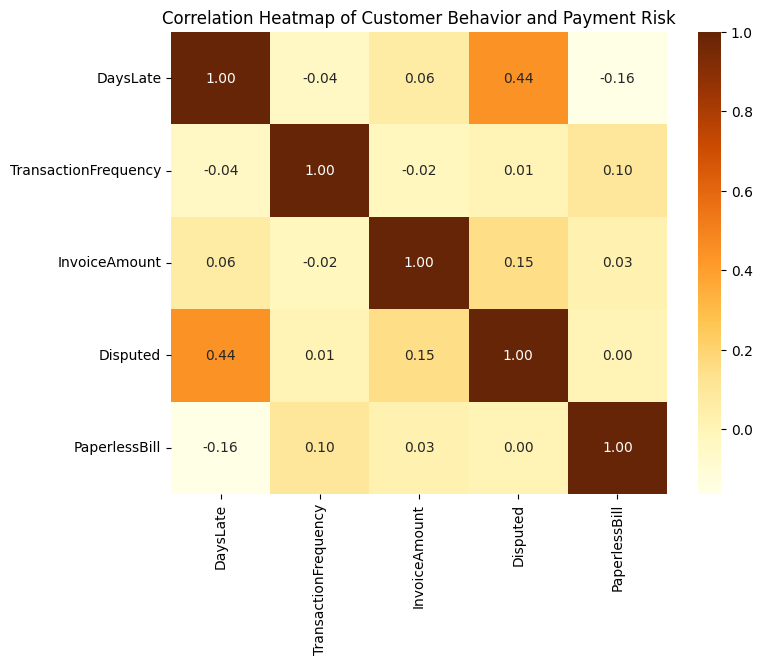

In [73]:

plt.figure(figsize=(8,6))
sns.heatmap(
    heatmap_data.corr(),
    annot=True,
    cmap='YlOrBr',
    fmt='.2f'
)
plt.title('Correlation Heatmap of Customer Behavior and Payment Risk')
plt.savefig(
    'correlation_heatmap.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

> **Disputed invoices** show the strongest association with late payments (0.44), while **transaction frequency** (−0.04) and invoice amount (0.06) have negligible impact.

> **PaperlessBill** shows a moderate negative correlation with delays (−0.16). -> When PaperlessBill increases, DaysLate tends to decrease, which means that electronic bills are typically paid earlier (with fewer late days) than paper bills.

> This suggests that prioritizing faster dispute resolution and promoting electronic billing will be more effective in reducing late payments than focusing on invoice amounts or increasing transaction volume alone.

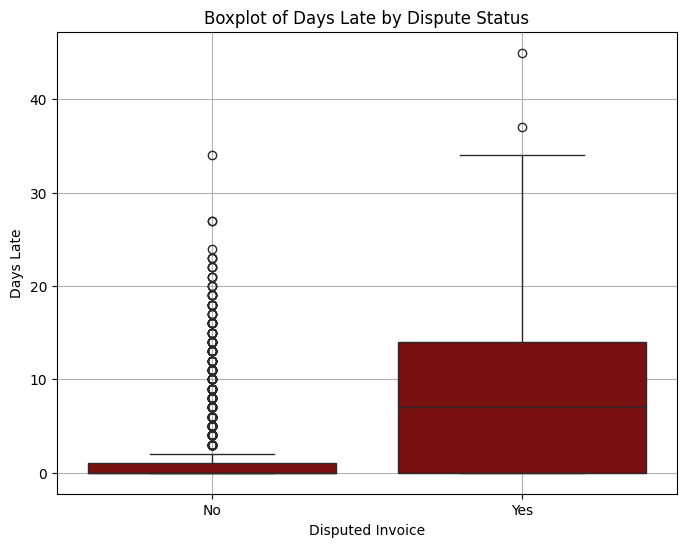

In [109]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Disputed', y='DaysLate', data=df, order=['No', 'Yes'], color='darkred')
plt.title('Boxplot of Days Late by Dispute Status')
plt.xlabel('Disputed Invoice')
plt.ylabel('Days Late')
plt.grid(True)
plt.savefig(
    'boxplot.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

The boxplot highlights a clear difference in Days Late between non-disputed and disputed invoices.

**Non-disputed invoices** are mostly paid on time, with the median ***close to zero*** and an extremely small IQR, indicating that payment behavior in this group is highly consistent.

In contrast, **disputed invoices** exhibit much ***longer delays*** and substantially higher variability. The median delay is around 7–8 days, and the IQR is wide, showing that the middle 50% of disputed invoices fall roughly between 0 and 15 days late.

Regarding **outliers**, both groups contain extreme cases:
* Disputed invoices show very large outliers, with delays reaching approximately 45 days, reflecting prolonged dispute resolution in certain cases.

* Although non-disputed invoices typically have near-zero delays, they also present several outliers (up to around 35 days), indicating that late payments can still occur even without formal disputes, though these cases are relatively rare.

Overall, the wider IQR and more extreme outliers in the disputed group reinforce the conclusion that disputes not only increase average payment delay but also introduce greater uncertainty into the payment cycle.

In [74]:
df.groupby('Disputed')['DaysLate'].mean().round(2)

,DaysLate
Disputed,
No,1.93
Yes,8.58


In [75]:
df.groupby('PaperlessBill')['DaysLate'].mean().round(2)

,DaysLate
PaperlessBill,
Electronic,2.39
Paper,4.44


### **Aging report**

In [76]:
df['AgingBucket'].value_counts()

,count
AgingBucket,
On-time,1589
0–30,869
31–60,8


In [77]:
df.groupby('AgingBucket')['InvoiceAmount'].sum()


,InvoiceAmount
AgingBucket,
0–30,53399.26
31–60,561.52
On-time,93742.40


In [78]:
df['AgingBucket'].value_counts(dropna=False)


,count
AgingBucket,
On-time,1589
0–30,869
31–60,8


/tmp/ipython-input-2124348941.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


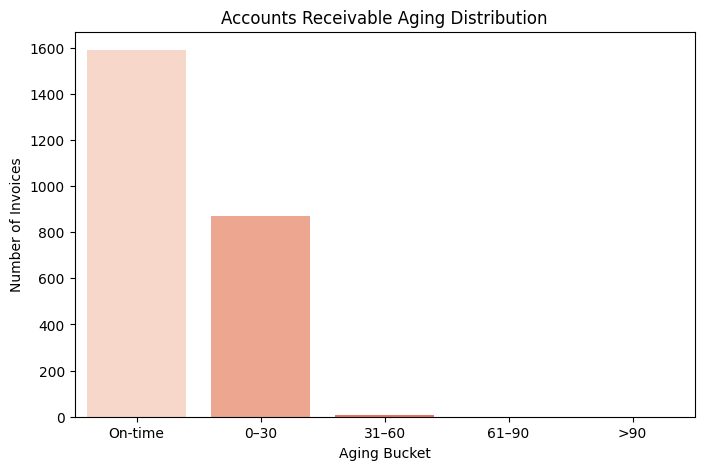

In [79]:
plt.figure(figsize=(8,5))
sns.countplot(
    x='AgingBucket',
    data=df,
    order=['On-time', '0–30', '31–60', '61–90','>90'],
    palette='Reds'
)
plt.title('Accounts Receivable Aging Distribution')
plt.xlabel('Aging Bucket')
plt.ylabel('Number of Invoices')
plt.savefig(
    'AgingDistriburion.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()


>The company has good receivables management with almost no seriously overdue invoices. Focusing gentle reminders on the 0–30 days group can further optimize cash flow.

### **Delay Payments By Country**

*Country-level analysis is conducted using country codes as provided in the dataset.*

*Due to the **synthetic nature** of the data, several country codes do not match standard country reference tables, and therefore country names are not mapped to avoid incorrect assumptions.*




In [80]:
df.groupby('countryCode')['PaymentStatus'].mean().round(2)

,PaymentStatus
countryCode,
391,0.25
406,0.42
770,0.39
818,0.41
897,0.33


In [81]:
mean_late_country = df.groupby('countryCode')['DaysLate'].mean().round(2)

/tmp/ipython-input-3622157732.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_late_country.index, y=mean_late_country.values, palette='Greens')


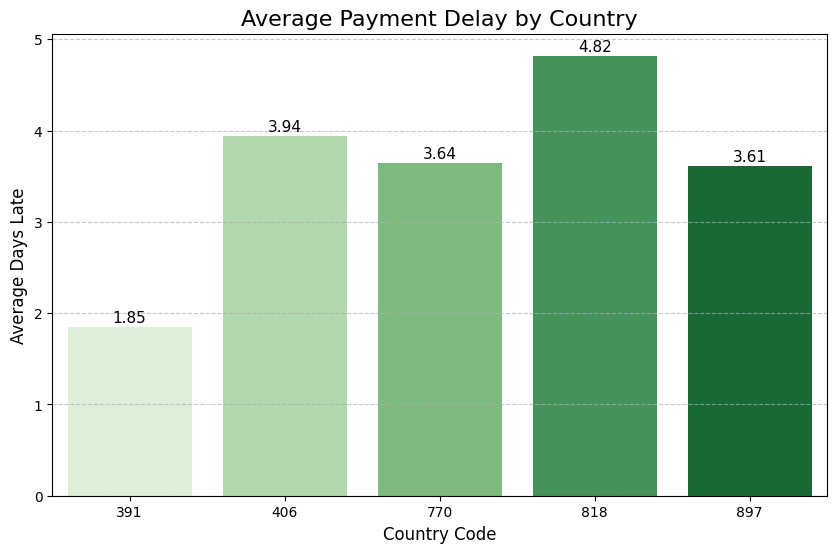

In [82]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_late_country.index, y=mean_late_country.values, palette='Greens')

plt.title('Average Payment Delay by Country', fontsize=16)
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Average Days Late', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_late_country.values):
    plt.text(i, value + 0.05, str(value), ha='center', fontsize=11)

plt.savefig(
    'DelaybyCountry.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

>* **Country 818** has the highest payment delays
Average 4.82 days late -> potential collection challenges in this region.
-> Implement earlier reminders, automated follow-up emails, or assign dedicated collectors to monitor invoices from this area more closely.

>* **Country 391** performs the best
Lowest average delay at only 1.85 days -> customers from this country pay fastest and most reliably.
-> Offer extended credit limits or reduced deposit requirements to encourage higher sales volume.

### **Delay Payments By Month**

In [83]:
df['InvoiceMonth'] = pd.to_datetime(df['InvoiceDate']).dt.month

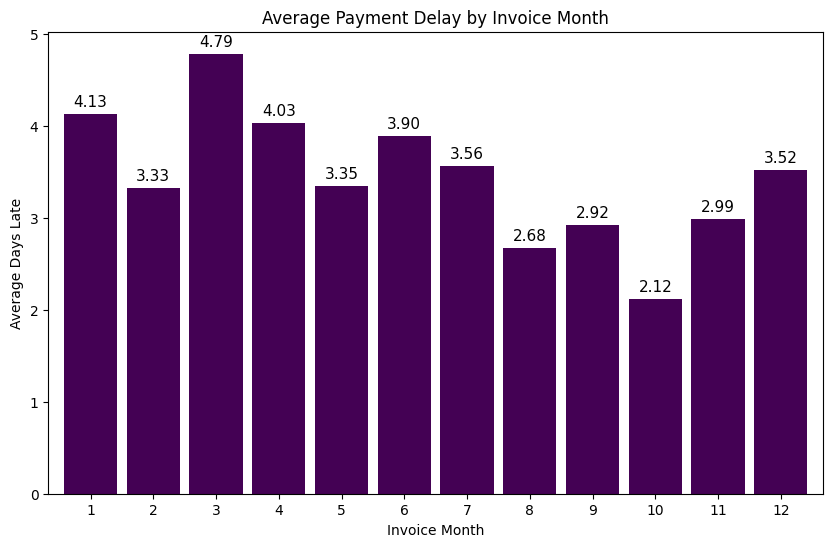

In [84]:
from matplotlib import colors
monthly_delay = df.groupby('InvoiceMonth')['DaysLate'].mean()

plt.figure(figsize=(10, 6))
bars = monthly_delay.plot(kind='bar', width=0.85, colormap='viridis')
plt.title('Average Payment Delay by Invoice Month')
plt.xlabel('Invoice Month')
plt.ylabel('Average Days Late')
plt.xticks(rotation=0)

for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=11)

plt.show()

> The average payment delay **ranges from 2.1 to 4.8 days** across the year.
> * Delays are **highest in March** (around 4.8 days) and remain relatively high in the first half of the year (above 3.3 days).
> * From August onward, the average delay decreases significantly, reaching the **lowest point in October** (about 2.1 days), before slightly increasing again toward the end of the year.

### **Time-series analysis (cash inflow)**

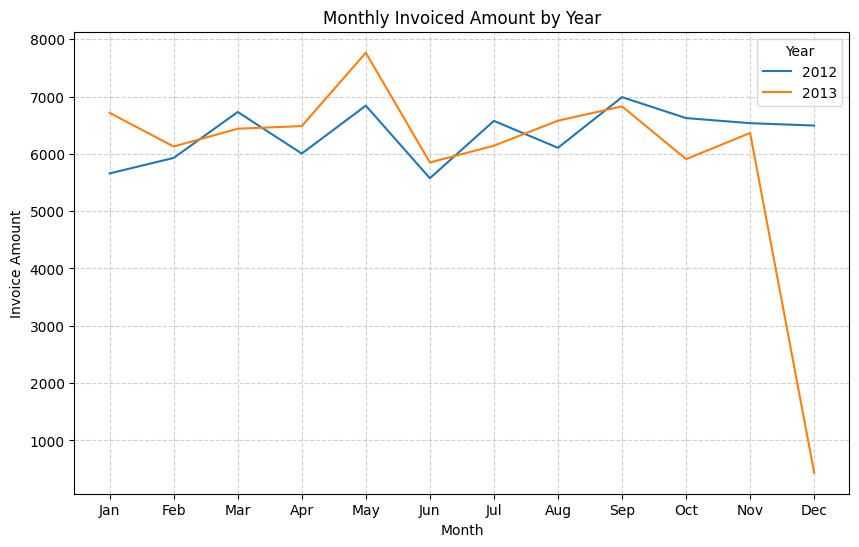

In [85]:
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonthNum'] = df['InvoiceDate'].dt.month

monthly_cash_by_year = df.groupby(['InvoiceYear', 'InvoiceMonthNum'])['InvoiceAmount'].sum().unstack(level=0)

plt.figure(figsize=(10, 6))
monthly_cash_by_year.plot(ax=plt.gca())
plt.title('Monthly Invoiced Amount by Year')
plt.xlabel('Month')
plt.ylabel('Invoice Amount')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(
    'Delaybymonth.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

> The time-series analysis reveals a strong **annual seasonal pattern** in monthly invoiced amounts. In both 2012 and 2013, invoicing peaks sharply in **March–April**, followed by a steady decline throughout the year, reaching near-zero levels by year-end.

> Notably, 2013 exhibits lower peaks and a steeper decline compared to 2012, suggesting a reduction in overall business volume or customer activity.

> **Recommendation**: To manage cash flow effectively, the company should build reserves during low periods, intensify collection efforts in peak months, and consider seasonal adjustments to credit terms or sales incentives.

## **CUSTOMER SEGMENTATION**

In [86]:
total_invoices = df['customerID'].value_counts()

In [87]:
late_invoices = df[df['DaysLate'] > 0]['customerID'].value_counts()

In [88]:
customer_df = pd.DataFrame({
    'TotalInvoices': total_invoices,
    'LateInvoices': late_invoices
}).fillna(0)

In [89]:
customer_df['LateRatio'] = customer_df['LateInvoices'] / customer_df['TotalInvoices']

In [90]:
avg_days_late = df.groupby('customerID')['DaysLate'].mean()
customer_df['AvgDaysLate'] = avg_days_late


In [91]:
customer_df['RiskGroup'] = np.where(
    (customer_df['LateRatio'] > 0.5) | (customer_df['AvgDaysLate'] > 10),
    'High Risk',
    np.where(
        customer_df['LateRatio'] > 0.2,
        'Medium Risk',
        'Low Risk'))

In [92]:
customer_df['RiskGroup'].value_counts()

,count
RiskGroup,
Low Risk,45
High Risk,34
Medium Risk,21


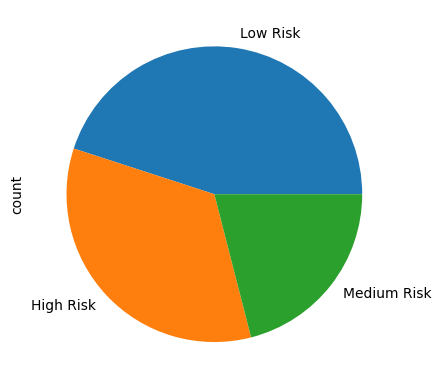

In [93]:
customer_df['RiskGroup'].value_counts().plot(kind='pie')
plt.savefig(
    'Riskpie.png',
    dpi=300,
    bbox_inches='tight'
)

## **STATISTICAL MODEL**

In [94]:
df_model = df.copy()

In [95]:
df['Disputed'].unique()


array(['No', 'Yes'], dtype=object)

In [96]:
df['PaperlessBill'].unique()


array(['Paper', 'Electronic'], dtype=object)

In [97]:
df_model['Disputed'] = df_model['Disputed'].map({'Yes': 1, 'No': 0})
df_model['PaperlessBill'] = (
    df_model['PaperlessBill'].map({'Electronic': 1, 'Paper': 0}))


In [98]:
df_model[
    ['InvoiceAmount', 'Disputed', 'PaperlessBill',
     'TransactionFrequency', 'DaysLate']].dtypes


,0
InvoiceAmount,float64
Disputed,int64
PaperlessBill,int64
TransactionFrequency,int64
DaysLate,int64


In [99]:
X = df_model[
    ['InvoiceAmount', 'Disputed', 'PaperlessBill', 'TransactionFrequency']]

In [100]:
X.isnull().sum()

,0
InvoiceAmount,0
Disputed,0
PaperlessBill,0
TransactionFrequency,0


In [101]:
y = df_model['DaysLate']

X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

df_ols = pd.concat([X, y], axis=1).dropna()

X = df_ols[X.columns]
y = df_ols['DaysLate']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               DaysLate   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     178.3
Date:                Tue, 30 Dec 2025   Prob (F-statistic):          2.93e-134
Time:                        13:37:20   Log-Likelihood:                -7720.0
No. Observations:                2466   AIC:                         1.545e+04
Df Residuals:                    2461   BIC:                         1.548e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.9573 

***From the above results, the multiple regression equation is expressed as follows:***

```
DaysLate = 3.9573 - 0.0008 * InvoiceAmount   + 6.6684 * Disputed  - 2.0422 * PaperlessBill - 0.0387 * TransactionFrequency
```

The model achieves an **R-squared** of 0.225 and an adjusted R-squared of 0.223, suggesting that approximately **22.5%** of the variation in payment delay is explained by the included variables.

* **Invoice disputes (Disputed)** have the strongest effect on payment delay. Disputed invoices are paid, on average, 6.67 days later than non-disputed invoices

* **Electronic billing (PaperlessBill)** significantly reduces payment delay. Invoices issued electronically are paid approximately 2.04 days earlier than paper-based invoices (p < 0.001), suggesting that billing digitalization improves payment timeliness.

* **Transaction frequency** shows a small negative effect on payment delay (–0.039 days, p = 0.098)

* **Invoice amount** is not statistically significant (p = 0.891)


## **SUMMARY**

The analysis reveals that disputed invoices significantly prolong payment delays by ~6.67 days, while electronic billing accelerates payments by ~2.04 days. Invoice amount and transaction frequency show negligible effects, with the model explaining 22.5% of variance in late payments, highlighting opportunities for dispute resolution and digitalization to optimize accounts receivable.

## **EXTRACT DATASET**

In [ ]:
df.to_excel('AR dataset.xlsx', index=False, engine='openpyxl')

In [ ]:
from google.colab import files
files.download('AR dataset.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Author:** Nhi Le